# 准备

In [1]:
import os
import sys

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plt_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()
    w, h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h), (x*(w+pad)+pad):(x*(w+pad)+pad+w)]=images[y*n_cols+x]
        plt.imshow(image, cmap="Greys", interpolation="nearest")
        plt.axis("off")

# 使用线性Autoencoder进行主成分分析(PCA)

In [2]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [4]:
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [5]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
        coding_val = codings.eval(feed_dict={X: X_test})

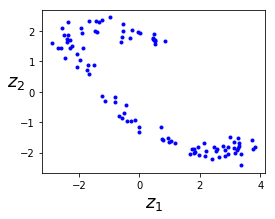

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(coding_val[:, 0], coding_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

# Stacked Autoencoders

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist  = input_data.read_data_sets("tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tmp/data/train-labels-idx1-ubyte.gz
Extracting tmp/data/t10k-images-idx3-ubyte.gz
Extracting tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## 一次性训练所有层

In [8]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

my_dense_layer = partial(tf.layers.dense,
                        activation=tf.nn.elu,
                        kernel_initializer=he_init,
                        kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [9]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "autoencoder/my_model_all_layers.ckpt")

09% Train MSE: 0.020302307
19% Train MSE: 0.011643166
29% Train MSE: 0.010225781
39% Train MSE: 0.009899946
49% Train MSE: 0.010377405


In [10]:
def show_reconstruction_digits(X, outputs, model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from autoencoder/my_model_all_layers.ckpt


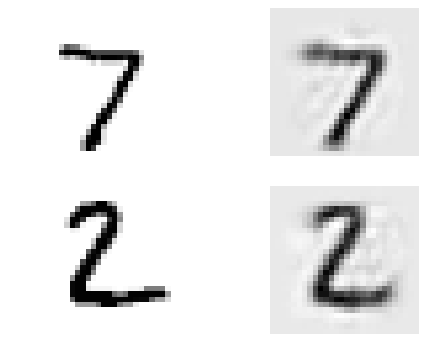

In [11]:
show_reconstruction_digits(X, outputs, "autoencoder/my_model_all_layers.ckpt")

## 调整权重

In [14]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [15]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")
weights4 = tf.transpose(weights1, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [17]:
saver = tf.train.Saver()

In [18]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "autoencoder/my_model_tying_weights.ckpt")

09% Train MSE: 0.015066842
19% Train MSE: 0.016488561
29% Train MSE: 0.017375803
3 Train MSE: 0.016878227
49% Train MSE: 0.015587644


INFO:tensorflow:Restoring parameters from autoencoder/my_model_tying_weights.ckpt


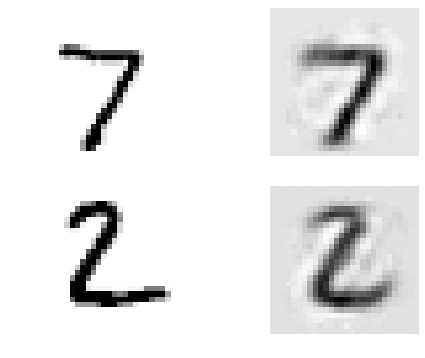

In [19]:
show_reconstruction_digits(X, outputs, "autoencoder/my_model_tying_weights.ckpt")

## Training one Autoencoder at a time in multiple graphs

In [20]:
reset_graph()

In [30]:
from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                     learning_rate=0.01, l2_reg=0.0005, seed=42,
                     hidden_activation=tf.nn.elu,
                     output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)
        
        n_inputs = X_train.shape[1]
        
        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg)
        )
        
        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")
        
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
        
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            init.run()
            for epoch in range(n_epochs):
                n_batches = len(X_train) // batch_size
                for iteration in range(n_batches):
                    print("\r{}%".format(100 * iteration // n_batches), end="")
                    sys.stdout.flush()
                    indices = rnd.permutation(len(X_train))[:batch_size]
                    X_batch = X_train[indices]
                    sess.run(training_op, feed_dict={X: X_batch})
                loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
                print("\r{}".format(epoch), "Train MSE:", loss_train)
            params = dict([(var.name, var.eval()) 
                           for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
            hidden_val = hidden.eval(feed_dict={X: X_train})
            return hidden_val, params["hidden/kernel:0"],params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [31]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images,
                                                  n_neurons=300, n_epochs=4,
                                                  batch_size=150, output_activation=None)
_, W2,b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, 
                                     n_epochs=4, batch_size=150)

09% Train MSE: 0.01731089
1 Train MSE: 0.01940918
29% Train MSE: 0.018998075
39% Train MSE: 0.018011808
09% Train MSE: 0.0043478985
19% Train MSE: 0.004751035
29% Train MSE: 0.00453082
3 %Train MSE: 0.0048460434


In [33]:
reset_graph()

n_inputs = 28 * 28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

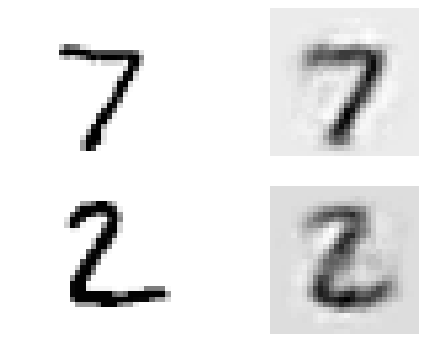

In [34]:
show_reconstruction_digits(X, outputs)